# Packages

In [251]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sympy as sym
from sympy import *
from matplotlib import cm

from numpy import trapz
import time
import scipy
import math
from sympy import symbols

import csv, sqlite3

import prettytable
prettytable.DEFAULT = 'DEFAULT'
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import random
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import joblib
import os
from sklearn.metrics import silhouette_score

%load_ext sql

matplotlib.rc('font',family='Times New Roman',size = 18)
plt.rcParams['figure.figsize'] = [12,7]

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Data pre-processing

Starting with the COVID data from the CDC website, we construct two data frames that we can analyze..

## uptake_df

| Column | Description |
| --- | --- |
| days | Number of days since the start of data collection|
| location | State |
| percent_vaccinated | Percentage of individuals who are fully vaccinated |


## stats_df

| Column | Description |
| --- | --- |
| location | State |
| political_party | Democratic, republican, or swing state in 2020 |
| final_uptake | Percent of individuals that are fully vaccinated at the final day |
| initial_uptake_slope | Average of over first 3 weeks|
| time_to_reach_40 | Number of days it takes to reach 40% vaccine uptake |
| weekly_uptake_std | Uptake volatility, standard deviation of weekly uptake |

In [8]:
## Create new database and open database connection

con = sqlite3.connect("COVID.db")
cur = con.cursor()

%sql sqlite:///COVID.db

## Read CSV file

COVIDdf = pd.read_csv('/Users/tinastuckey/Desktop/VaccineGithubCSV/COVID_Vaccine_CDC_Data.csv')
COVIDdf.to_sql("COVID", con, if_exists='replace')

## Preprocess the data 

%sql DROP TABLE IF EXISTS COVIDsimp;

%sql CREATE TABLE COVIDsimp (DATE DATE,DAYS INT(4), LOCATION VARCHAR(3), \
                 DOSE1_PCT DECIMAL(7,2), \
                 DOSE2_PCT DECIMAL(6,2));

%sql INSERT INTO COVIDsimp SELECT DATE,DAYS, LOCATION, ADMINISTERED_DOSE1_POP_PCT, \
            SERIES_COMPLETE_POP_PCT FROM COVID WHERE SERIES_COMPLETE_POP_PCT > 0;

COVIDsimpdf = pd.read_sql('SELECT * FROM COVIDsimp',con)

 * sqlite:///COVID.db
Done.
 * sqlite:///COVID.db
Done.
 * sqlite:///COVID.db
14884 rows affected.


In [52]:
## Uptake df

days = np.array(COVIDsimpdf.loc[: , "DAYS"])
location = np.array(COVIDsimpdf.loc[: , "LOCATION"])
percent_vaccinated = np.array(COVIDsimpdf.loc[: , "DOSE1_PCT"])

uptake_df = pd.DataFrame({"days":days,
                   "location":location,"percent_vaccinated":percent_vaccinated})

uptake_df = uptake_df.sort_values(['location', 'days']) 
uptake_df = uptake_df[::7]

In [10]:
## Stats df

statement = 'SELECT DISTINCT(LOCATION) FROM COVIDsimp WHERE LOCATION NOT IN ("AS","DC","FM","GU","MH","MP","PR","RP","VI","US") AND LOCATION NOT LIKE "%2%" ORDER BY LOCATION'
df = pd.read_sql(statement,con)
location = df.loc[: , "LOCATION"]

# FINAL_UPTAKE

statement = 'SELECT DOSE2_PCT FROM (SELECT *, ROW_NUMBER() OVER (PARTITION BY LOCATION ORDER BY DOSE2_PCT DESC) AS row_number FROM COVIDsimp WHERE LOCATION NOT IN ("AS","DC","FM","GU","MH","MP","PR","RP","VI","US") AND LOCATION NOT LIKE "%2%" ) t WHERE t.row_number = 1'
df = pd.read_sql(statement,con)
final_uptake = df.loc[:,"DOSE2_PCT"]

# TIME TO REACH 40%

statement = 'SELECT DAYS FROM (SELECT *, ROW_NUMBER() OVER (PARTITION BY LOCATION) AS row_number FROM COVIDsimp WHERE DOSE2_PCT > 40 AND LOCATION NOT IN ("AS","DC","FM","GU","MH","MP","PR","RP","VI","US") AND LOCATION NOT LIKE "%2%") t WHERE t.row_number = 1'
df = pd.read_sql(statement,con)
time_to_reach_40 = df.loc[:,"DAYS"]

# WEEKLY UPTAKE
statement = 'SELECT LOCATION, DOSE2_PCT FROM (SELECT *, ROW_NUMBER() OVER (PARTITION BY LOCATION) AS row_number FROM COVIDsimp WHERE LOCATION NOT IN ("AS","DC","FM","GU","MH","MP","PR","RP","VI","US") AND LOCATION NOT LIKE "%2%") t WHERE t.row_number % 7 = 1'
df = pd.read_sql(statement,con)
weekly_uptake_data = df.loc[:,"DOSE2_PCT"]

initial_uptake = []
weekly_uptake_std = []

for j in range(0,50):
    var = [((weekly_uptake_data[35*j + k + 1 ] - weekly_uptake_data[35*j + k ])/weekly_uptake_data[35*j + k]) for k in range(0,3)]
    initial_uptake.append(np.average(var))
    var2 = [((weekly_uptake_data[35*j + k + 1] - weekly_uptake_data[35*j + k])/weekly_uptake_data[35*j + k]) for k in range(0,34)]
    weekly_uptake_std.append(np.std(var2))

repind = [1,0,2,12,14,15,16,17,23,24,25,27,35,39,40,41,43,48,49]  
swingind = [3,8,9,11,21,22,28,29,26,34,37,42,47]
political_party_2020 = []

for j in range(0,50):
    if j in repind:
        political_party_2020.append('Rep')
    elif j in swingind:
        political_party_2020.append('Swing')
    else:
        political_party_2020.append('Dem')

stats_df = pd.DataFrame({"location":location,
                        "political_party":political_party_2020,
                        "final_uptake":final_uptake,
                        "time_to_reach_40":time_to_reach_40,
                        "initial_uptake":initial_uptake,
                        "weekly_uptake_std": weekly_uptake_std})

In [12]:
## Close database connection

con.close()

# EDA & Visualization

## Visualization for uptake_df

### United States

Text(0.5, 1.0, 'Uptake curve for United States')

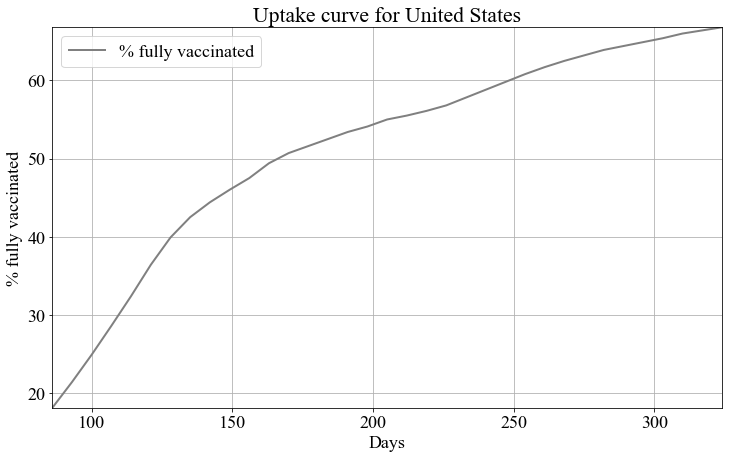

In [263]:
## Uptake curve for United States

loc_label = 'US'

plt.rcParams['figure.figsize'] = [12,7] 

US_df = uptake_df[uptake_df['location'] == loc_label].copy()
plt.plot(US_df['days'],US_df['percent_vaccinated'],'-',color = 'grey',linewidth = 2,label = '% fully vaccinated')
plt.xlim(min(US_df['days']),max(US_df['days']))
plt.ylim(min(US_df['percent_vaccinated']),max(US_df['percent_vaccinated']))
plt.xlabel('Days')
plt.ylabel('% fully vaccinated')
plt.grid()
plt.legend()
plt.title('Uptake curve for United States')

### Two states: West Virginia (WV) and Virginia (VA)

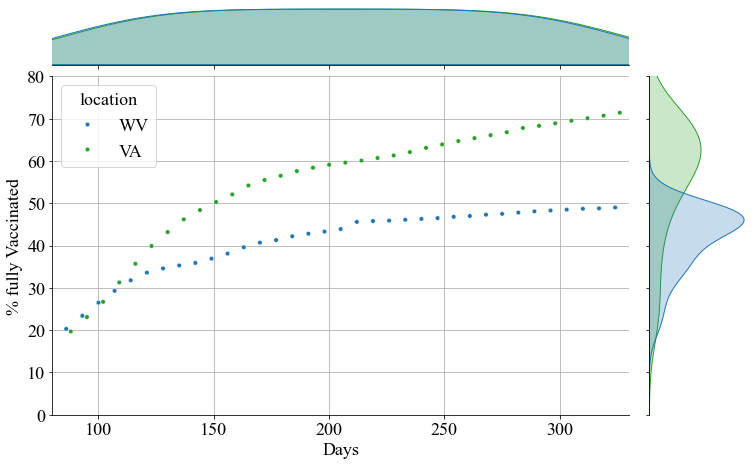

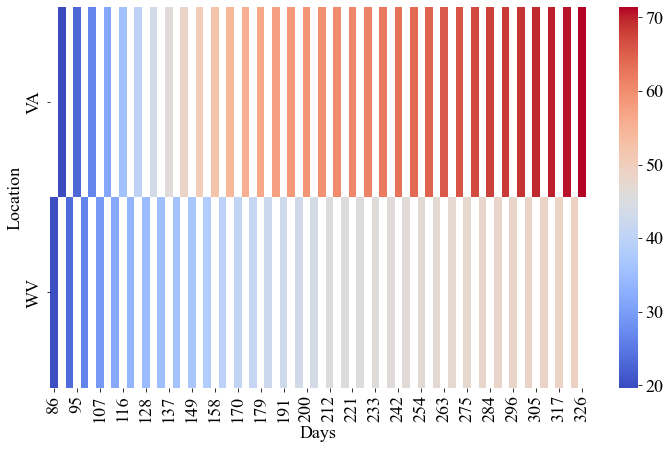

In [84]:
## Visualizing data from two states: WV (low uptake) and VA (high uptake)

LowHigh_df = pd.concat([uptake_df[uptake_df['location'] == 'WV'].copy(),uptake_df[uptake_df['location'] == 'VA'].copy()])
                       
colormap = {"WV": "tab:blue", "VA": "tab:green"}

g = sns.jointplot(LowHigh_df,x='days',y='percent_vaccinated',s=20, hue = 'location',palette = colormap,xlim = [80,330],ylim=[0,80],zorder=10)
g.fig.set_size_inches((12, 7))
# g.ax_marg_x.remove()
plt.xlabel('Days')
plt.ylabel('% fully Vaccinated')
plt.grid()
plt.show()

sns.heatmap(LowHigh_df.pivot(index="location", columns="days", values="percent_vaccinated"), cmap="coolwarm")
plt.xlabel('Days')
plt.ylabel('Location')

plt.show()

## Visualization for stats_df

### Histograms of all features

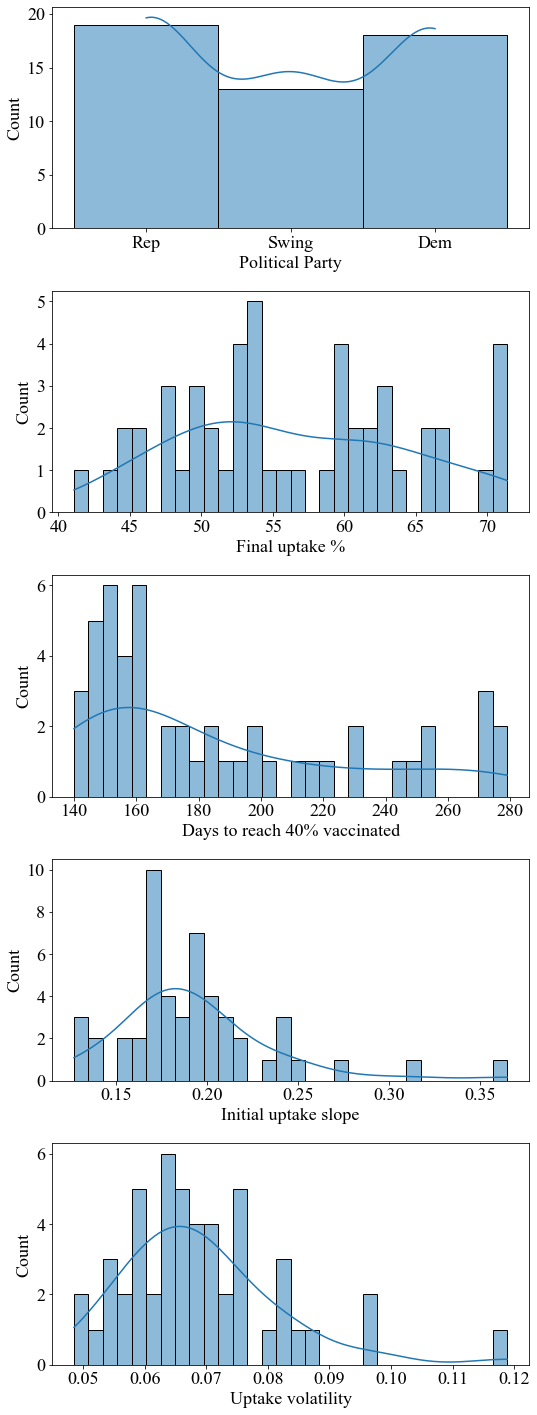

In [76]:
fig, ax = plt.subplots(nrows=5, ncols=1,figsize=(8,20))
xlab = ['Political Party','Final uptake %','Days to reach 40% vaccinated','Initial uptake slope','Uptake volatility']
for i, col in enumerate(stats_df.columns):
    if i > 0:
        sns.histplot(stats_df[col], bins=30, kde=True, ax=ax[i-1])
        ax[i-1].set_xlabel(xlab[i-1])

plt.tight_layout()
plt.show()

### Correlation heatmap for all features

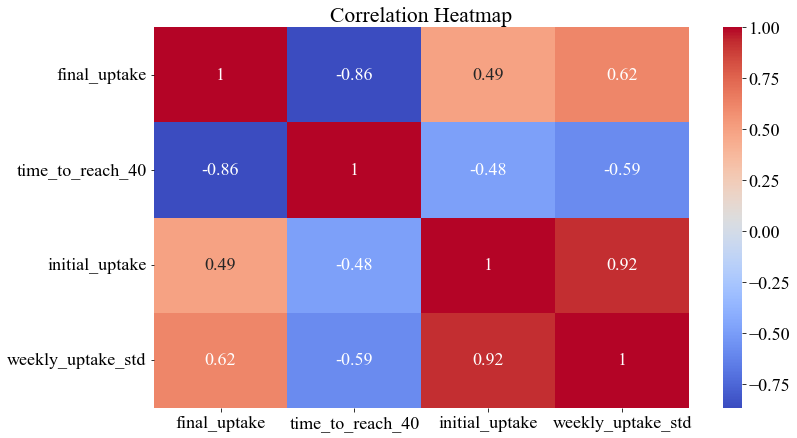

In [82]:
sns.heatmap(stats_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

### Pairplot of all features

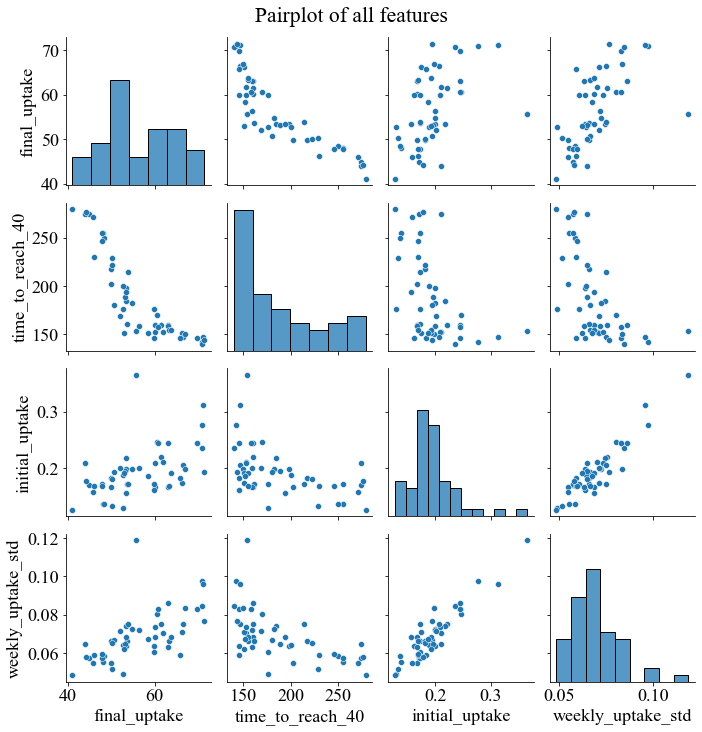

In [87]:
sns.pairplot(stats_df)
plt.suptitle("Pairplot of all features", y=1.02)
plt.show()

# Modeling

In [147]:
uptake_reg_df = uptake_df.sort_values(['location', 'days']) 

uptake_reg_df['lag_1'] = uptake_reg_df.groupby('location')['percent_vaccinated'].shift(1)
uptake_reg_df['lag_2'] = uptake_reg_df.groupby('location')['percent_vaccinated'].shift(2)
uptake_reg_df['lag_3'] = uptake_reg_df.groupby('location')['percent_vaccinated'].shift(3)
uptake_reg_df['rolling_avg_3'] = uptake_reg_df.groupby('location')['percent_vaccinated'].transform(lambda x: x.shift(1).rolling(3).mean())

uptake_reg_df['target'] = uptake_reg_df.groupby('location')['percent_vaccinated'].shift(-2)

features = ['lag_1', 'lag_2', 'lag_3', 'rolling_avg_3']
uptake_reg_df_model = uptake_reg_df.dropna(subset=features + ['target'])

X = uptake_reg_df_model[features]
y = uptake_reg_df_model['target']

uptake_reg_df_model

,days,location,percent_vaccinated,lag_1,lag_2,lag_3,rolling_avg_3,target
1308,104,AK,32.8,29.6,26.5,23.9,26.666667,36.3
1732,111,AK,34.5,32.8,29.6,26.5,29.633333,39.1
2147,118,AK,36.3,34.5,32.8,29.6,32.300000,40.7
2589,125,AK,39.1,36.3,34.5,32.8,34.533333,41.7
2995,132,AK,40.7,39.1,36.3,34.5,36.633333,42.6
...,...,...,...,...,...,...,...,...
12205,283,WY,47.7,47.0,46.0,45.3,46.100000,48.9
12684,290,WY,48.3,47.7,47.0,46.0,46.900000,49.4
13100,297,WY,48.9,48.3,47.7,47.0,47.666667,49.9
13512,304,WY,49.4,48.9,48.3,47.7,48.300000,50.5


## Linear Regression

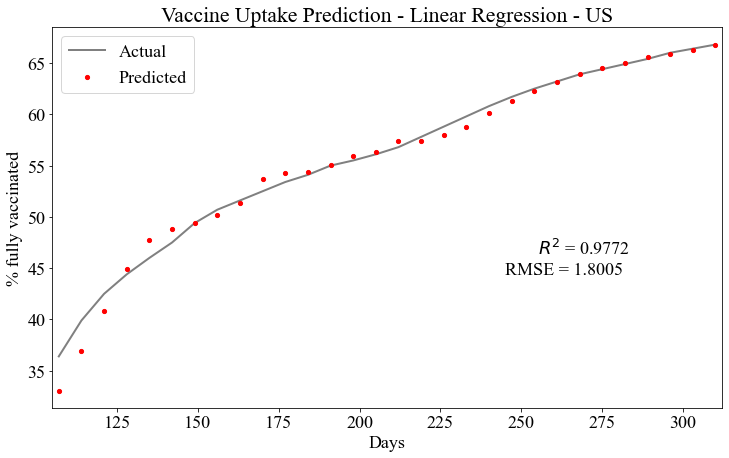

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1,random_state=2)

model = LinearRegression().fit(X_train, y_train )

percent_vacc_pred = model.predict(X_test)

state_to_plot = 'US'  

uptake_reg_df_plot = uptake_reg_df_model[uptake_reg_df_model['location'] == state_to_plot].copy()
uptake_reg_df_plot['predicted'] = model.predict(uptake_reg_df_plot[features])

r_sq = model.score(X_train, y_train)
rmse = np.sqrt(mean_squared_error(percent_vacc_pred,y_test))

plt.plot(uptake_reg_df_plot['days'], uptake_reg_df_plot['target'], '-',color = 'grey',linewidth = 2,label='Actual')

plt.scatter(uptake_reg_df_plot['days'], uptake_reg_df_plot['predicted'], marker = '.',s=70,color = 'red',label='Predicted',zorder=10)

plt.annotate(r'$R^2$ = {}'.format(round(r_sq,4)), xy=(255, min(uptake_reg_df_plot['target'])+10),color = 'k')
plt.annotate(r'RMSE = {}'.format(round(rmse,4)), xy=(245, min(uptake_reg_df_plot['target'])+8),color = 'k')

plt.title(f"Vaccine Uptake Prediction - Linear Regression - {state_to_plot}")
plt.xlim([min(uptake_reg_df_plot['days'])-2,max(uptake_reg_df_plot['days'])+2])

plt.xlabel("Days")
plt.ylabel("% fully vaccinated")
plt.legend(loc = 'best')
plt.show()

os.makedirs("models", exist_ok=True)

model_path = "models/xgb_vaccine_forecast_model_linear_regression.pkl"
joblib.dump(model, model_path)

uptake_reg_df_model.loc[:,'predicted'] = model.predict(X)
output_path = "models/vaccine_predictions_linear_regression.csv"
uptake_reg_df_model[['location', 'days', 'percent_vaccinated', 'target', 'predicted']].to_csv(output_path, index=False)


## Polynomial Regression

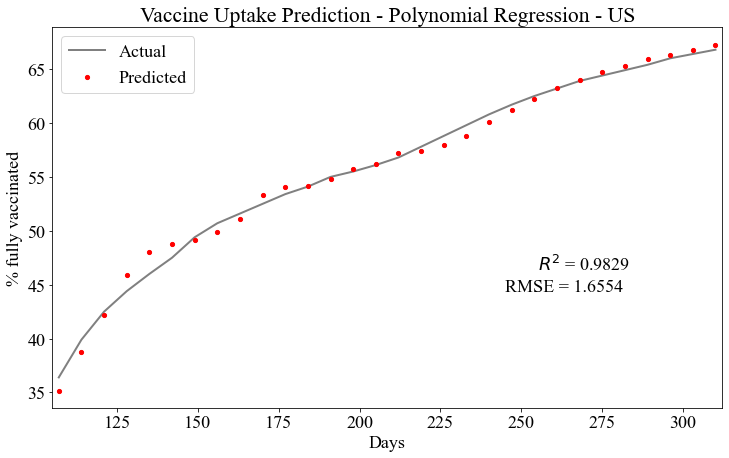

In [188]:
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(poly_features,y, test_size=0.1,random_state = 2)

model = LinearRegression().fit(X_train, y_train )

percent_vacc_pred = model.predict(X_test)

state_to_plot = 'US'  

uptake_reg_df_plot = uptake_reg_df_model[uptake_reg_df_model['location'] == state_to_plot].copy()
poly2 = poly.fit_transform(uptake_reg_df_plot[features])
uptake_reg_df_plot['predicted'] = model.predict(poly2)

r_sq = model.score(X_train, y_train)
rmse = np.sqrt(mean_squared_error(percent_vacc_pred,y_test))

plt.plot(uptake_reg_df_plot['days'], uptake_reg_df_plot['target'], '-',color = 'grey',linewidth = 2,label='Actual')

plt.scatter(uptake_reg_df_plot['days'], uptake_reg_df_plot['predicted'], marker = '.',s=70,color = 'red',label='Predicted',zorder=10)

plt.annotate(r'$R^2$ = {}'.format(round(r_sq,4)), xy=(255, min(uptake_reg_df_plot['target'])+10),color = 'k')
plt.annotate(r'RMSE = {}'.format(round(rmse,4)), xy=(245, min(uptake_reg_df_plot['target'])+8),color = 'k')

plt.title(f"Vaccine Uptake Prediction - Polynomial Regression - {state_to_plot}")
plt.xlim([min(uptake_reg_df_plot['days'])-2,max(uptake_reg_df_plot['days'])+2])

plt.xlabel("Days")
plt.ylabel("% fully vaccinated")
plt.legend(loc = 'best')
plt.show()

model_path = "models/xgb_vaccine_forecast_model_polynomial_regression.pkl"
joblib.dump(model, model_path)

uptake_reg_df_model.loc[:,'predicted'] = model.predict(poly.fit_transform(X))
output_path = "models/vaccine_predictions_polynomial_regression.csv"
uptake_reg_df_model[['location', 'days', 'percent_vaccinated', 'target', 'predicted']].to_csv(output_path, index=False)

## Random Forest Regression

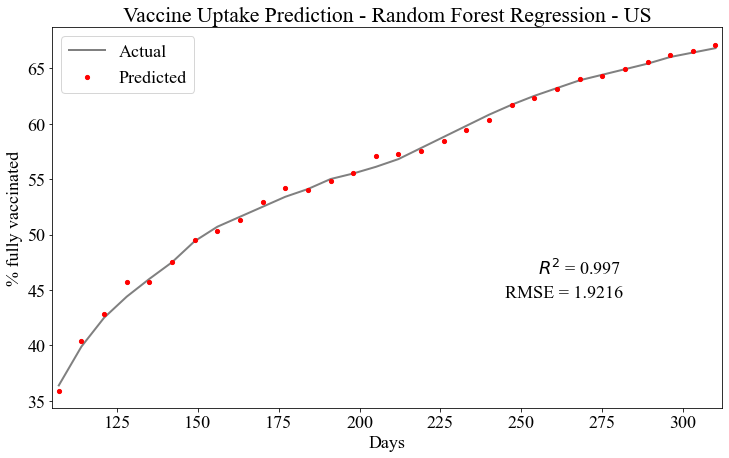

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1,random_state=2)

model = RandomForestRegressor(n_estimators=100,random_state=0).fit(X_train,y_train)

percent_vacc_pred = model.predict(X_test)

state_to_plot = 'US'  

uptake_reg_df_plot = uptake_reg_df_model[uptake_reg_df_model['location'] == state_to_plot].copy()
uptake_reg_df_plot['predicted'] = model.predict(uptake_reg_df_plot[features])

r_sq = model.score(X_train, y_train)
rmse = np.sqrt(mean_squared_error(percent_vacc_pred,y_test))

plt.plot(uptake_reg_df_plot['days'], uptake_reg_df_plot['target'], '-',color = 'grey',linewidth = 2,label='Actual')

plt.scatter(uptake_reg_df_plot['days'], uptake_reg_df_plot['predicted'], marker = '.',s=70,color = 'red',label='Predicted',zorder=10)

plt.annotate(r'$R^2$ = {}'.format(round(r_sq,4)), xy=(255, min(uptake_reg_df_plot['target'])+10),color = 'k')
plt.annotate(r'RMSE = {}'.format(round(rmse,4)), xy=(245, min(uptake_reg_df_plot['target'])+8),color = 'k')

plt.title(f"Vaccine Uptake Prediction - Random Forest Regression - {state_to_plot}")
plt.xlim([min(uptake_reg_df_plot['days'])-2,max(uptake_reg_df_plot['days'])+2])

plt.xlabel("Days")
plt.ylabel("% fully vaccinated")
plt.legend(loc = 'best')
plt.show()

model_path = "models/xgb_vaccine_forecast_model_random_forest_regression.pkl"
joblib.dump(model, model_path)

uptake_reg_df_model.loc[:,'predicted'] = model.predict(X)
output_path = "models/vaccine_predictions_random_forest_regression.csv"
uptake_reg_df_model[['location', 'days', 'percent_vaccinated', 'target', 'predicted']].to_csv(output_path, index=False)


## XGBoost

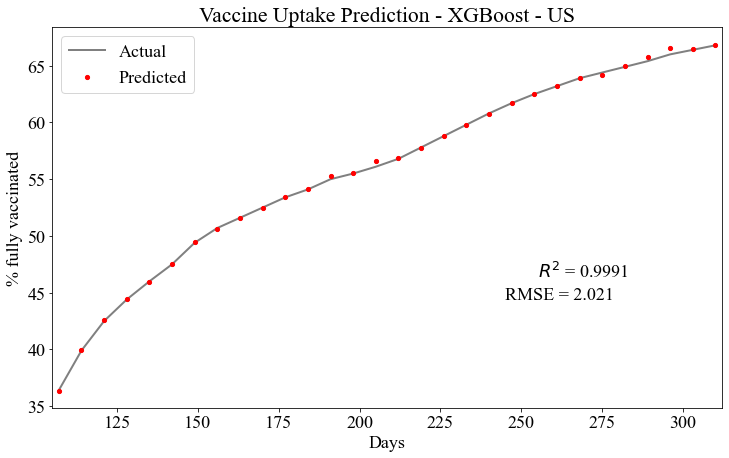

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1,random_state=2)

model = XGBRegressor(n_estimators=1000, learning_rate=0.2, random_state=2).fit(X_train,y_train)

percent_vacc_pred = model.predict(X_test)

state_to_plot = 'US'  

uptake_reg_df_plot = uptake_reg_df_model[uptake_reg_df_model['location'] == state_to_plot].copy()
uptake_reg_df_plot['predicted'] = model.predict(uptake_reg_df_plot[features])

r_sq = model.score(X_train, y_train)
rmse = np.sqrt(mean_squared_error(percent_vacc_pred,y_test))

plt.plot(uptake_reg_df_plot['days'], uptake_reg_df_plot['target'], '-',color = 'grey',linewidth = 2,label='Actual')

plt.scatter(uptake_reg_df_plot['days'], uptake_reg_df_plot['predicted'], marker = '.',s=70,color = 'red',label='Predicted',zorder=10)

plt.annotate(r'$R^2$ = {}'.format(round(r_sq,4)), xy=(255, min(uptake_reg_df_plot['target'])+10),color = 'k')
plt.annotate(r'RMSE = {}'.format(round(rmse,4)), xy=(245, min(uptake_reg_df_plot['target'])+8),color = 'k')

plt.title(f"Vaccine Uptake Prediction - XGBoost - {state_to_plot}")
plt.xlim([min(uptake_reg_df_plot['days'])-2,max(uptake_reg_df_plot['days'])+2])

plt.xlabel("Days")
plt.ylabel("% fully vaccinated")
plt.legend(loc = 'best')
plt.show()

model_path = "models/xgb_vaccine_forecast_model_XGboost_regression.pkl"
joblib.dump(model, model_path)

uptake_reg_df_model.loc[:,'predicted'] = model.predict(X)
output_path = "models/vaccine_predictions_XGboost_regression.csv"
uptake_reg_df_model[['location', 'days', 'percent_vaccinated', 'target', 'predicted']].to_csv(output_path, index=False)


# Clustering

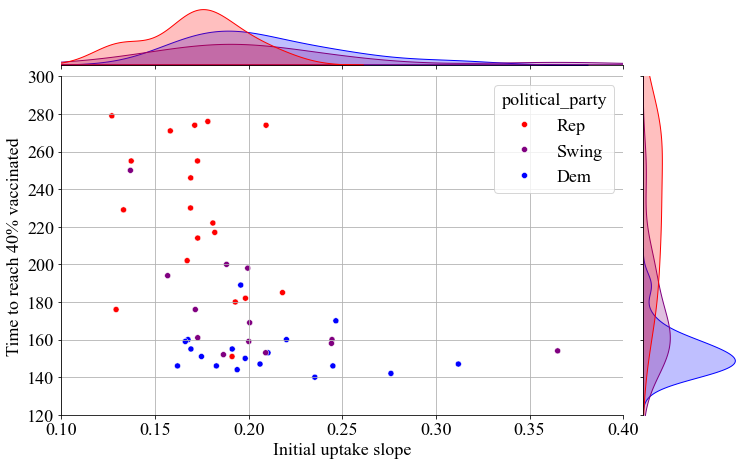

In [253]:
colormap = {"Rep": "red", "Swing": "purple","Dem": "blue"}

g = sns.jointplot(data = stats_df, x = 'initial_uptake', y = 'time_to_reach_40', hue = 'political_party', palette = colormap,xlim=[0.1,0.4],ylim=[120,300])
g.fig.set_size_inches((12, 7))
plt.xlabel('Initial uptake slope')
plt.ylabel('Time to reach 40% vaccinated')
plt.grid()
plt.show()


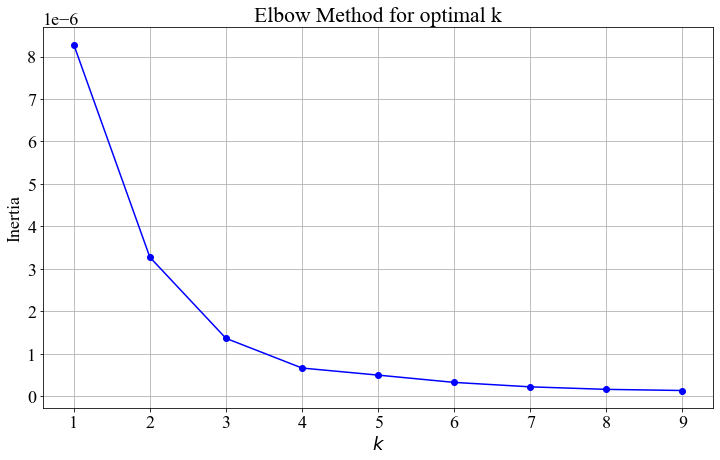

Accuracy of political party prediction: 54.00%


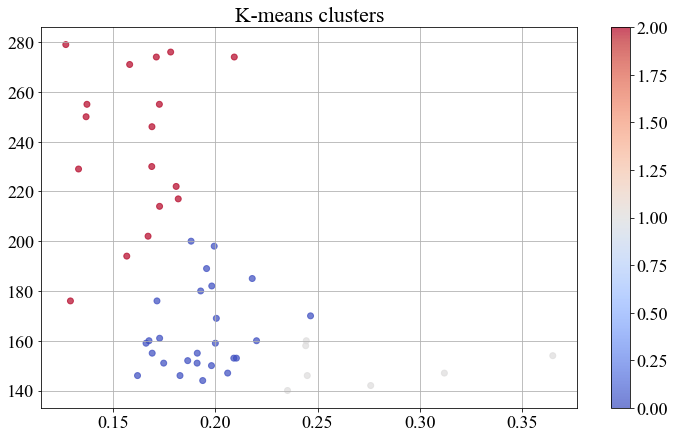

In [283]:
X = stats_df[['initial_uptake', 'time_to_reach_40']]
X_norm = preprocessing.normalize(stats_df[['initial_uptake', 'time_to_reach_40']])

kmeans_diff_k = [KMeans(n_clusters=k, random_state=2).fit(X_norm) for k in range(1, 10)]
inertia = [model.inertia_ for model in kmeans_diff_k]

plt.plot(range(1,10), inertia, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.grid(True)
plt.title("Elbow Method for optimal k")
plt.show()

kmeans = KMeans(n_clusters=3, random_state = 2).fit(X_norm)
kmeans_df = pd.DataFrame({'initial_uptake':np.array(X)[:,0],
                        'time_to_reach_40':np.array(X)[:,1]})

repind = [1,0,2,12,14,15,16,17,23,24,25,27,35,39,40,41,43,48,49]  
swingind = [3,8,9,11,21,22,28,29,26,34,37,42,47]
political_party_2020_ind = []

for j in range(0,50):
    if j in repind:
        political_party_2020_ind.append(2)
    elif j in swingind:
        political_party_2020_ind.append(0)
    else:
        political_party_2020_ind.append(1)
        
kmeans_df['cluster'] = kmeans.labels_
# kmeans_df['target_group'] = pd.qcut(stats_df['time_to_reach_40'], q=3, labels=False)
kmeans_df['target_group'] = political_party_2020_ind

accuracy = (kmeans_df['cluster'] == kmeans_df['target_group']).mean()
print(f"Accuracy of political party prediction: {accuracy:.2%}")

plt.scatter(kmeans_df['initial_uptake'],kmeans_df['time_to_reach_40'], c=kmeans_df['cluster'], cmap='coolwarm', alpha=0.7)
plt.grid()
plt.colorbar()
plt.title("K-means clusters")
plt.show()


Text(0, 0.5, 'Final uptake %')

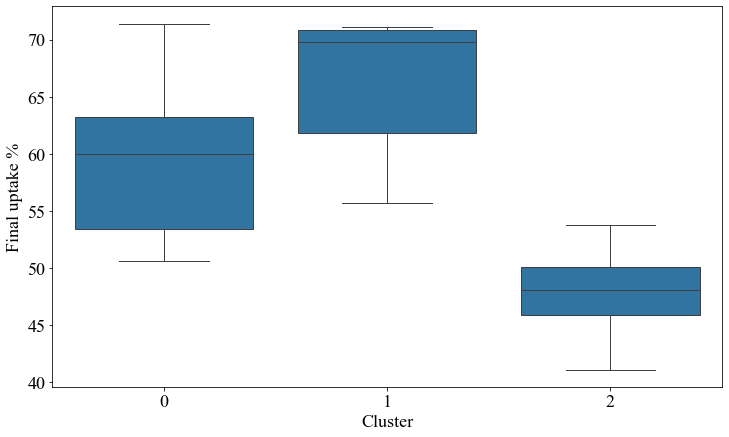

In [266]:
sns.boxplot(x = kmeans.labels_, y = stats_df['final_uptake'])
plt.xlabel('Cluster')
plt.ylabel('Final uptake %')

Cluster 2: States with lower initial uptake slope (low early enthusiasm/hesitant) and take a long time to reach 40% vaccination
Cluster 0: States with higher initial uptake slope and shorter time to reach 40%
Cluster 1: States that are most enthusiastic and reach 40% vaccination quickly

As expected, states that were not enthusiastic about getting vaccinated initially (cluster 2) end up with a  final uptake percentage that is low and states that were very enthusiastic (cluster 1) end up with highest final uptake rate  